In [1]:
import numpy as np
import pandas as pd

images = []
lesions = []
from skimage.io import imread
root = "PH2Dataset"

#reading files from input

import os 
for root, dirs, files in os.walk('/kaggle/input/ph2dataset/PH2Dataset/PH2_Dataset/'):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))
len(images), len(lesions)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(200, 200)

In [2]:
# changing pucture sizes to 256х256
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


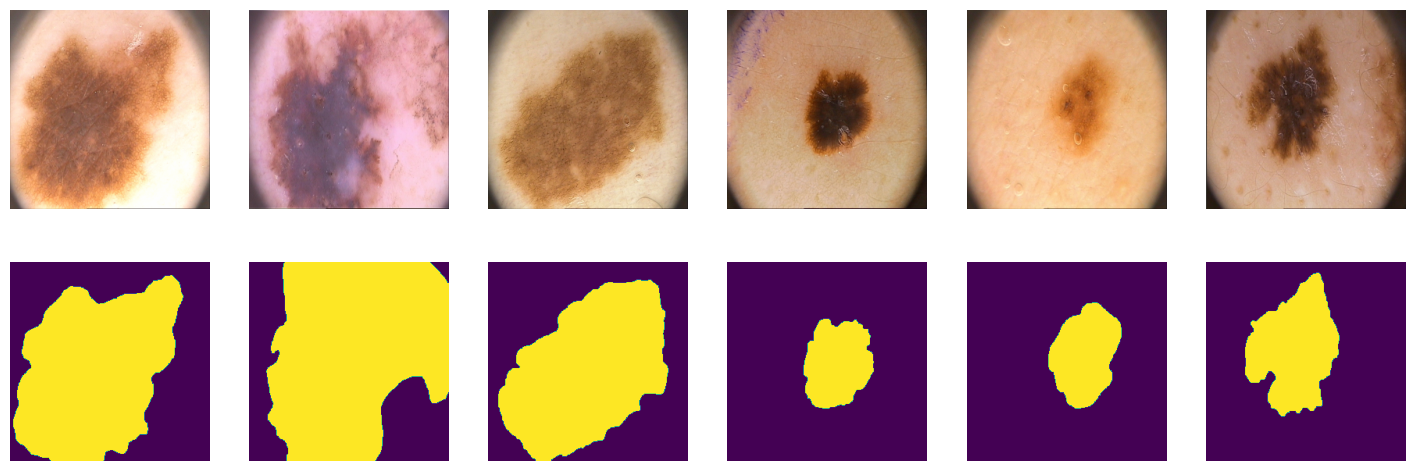

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [6]:
print(len(tr), len(val), len(ts))

100 50 50


In [7]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential (
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        e0, i0 = self.pool0(self.enc_conv0(x))
        e1, i1 = self.pool1(self.enc_conv1(e0))
        e2, i2 = self.pool2(self.enc_conv2(e1))
        e3, i3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, i3))
        d1 = self.dec_conv1(self.upsample1(d0, i2))
        d2 = self.dec_conv2(self.upsample2(d1, i1))
        d3 = self.dec_conv3(self.upsample3(d2, i0))   # no activation
        return d3

In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

In [12]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-1 * y_pred))).mean()

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch):
    X_val, Y_val = next(iter(data_val))
    losses = {
        'train': [], 
        'valid': [],
    }
    scores = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        losses['train'].append(avg_loss.item())

        # show intermediate results
        model.eval()  # testing mode
        avg_loss = 0
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
                loss = loss_fn(Y_hat, Y_val)
                avg_loss += loss / len(data_val)
        losses['valid'].append(avg_loss.item())
        
        scores.append(score_model(model, metric, data_val))
        print(loss_fn(Y_val, Y_hat))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    return [losses, scores]

In [14]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [15]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        Y_pred = torch.where(Y_pred > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [16]:
model_bce = SegNet().to(device)

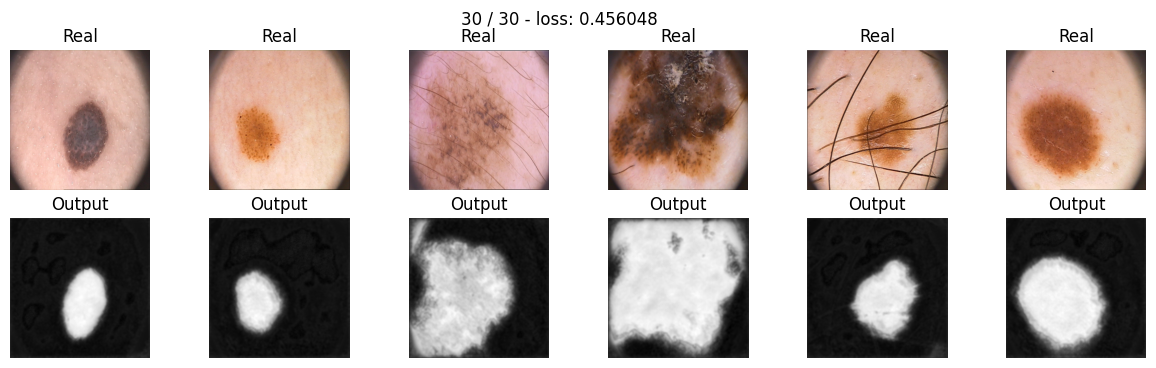

In [17]:
max_epochs = 30
bce_results, bce_accuracy = train(model_bce, optim.Adam(model_bce.parameters()), 
                                  bce_loss, max_epochs, data_tr, data_val)

In [18]:
print('VALID:\t', score_model(model_bce, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(model_bce, iou_pytorch, data_ts))

VALID:	 0.5879999995231628 
TEST:	 0.5539999604225159


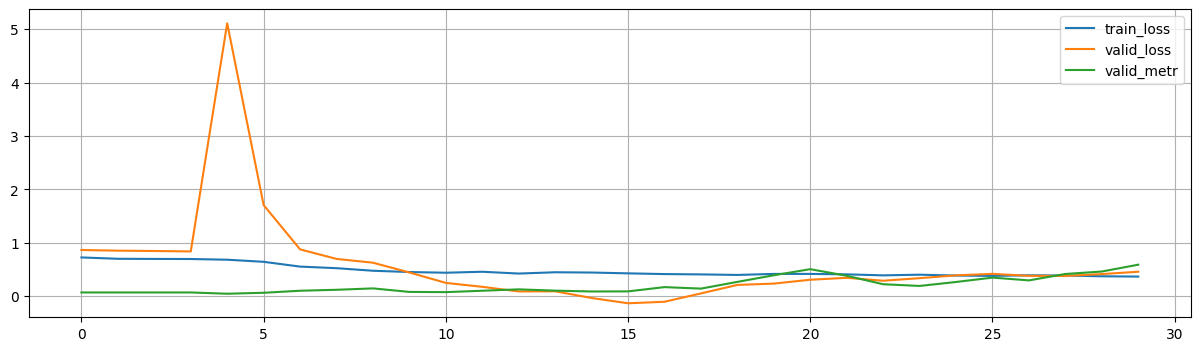

In [19]:
res, acc = bce_results, bce_accuracy
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [20]:
torch.cuda.empty_cache()

In [21]:
def dice_loss(y_real, y_pred, from_logits=True):
    if from_logits:
        y_pred = torch.sigmoid(y_pred)
    num = torch.sum(y_real * y_pred)
    den = torch.sum(y_real) + torch.sum(y_pred)
    res = 2 * num / (den + 1e-8) #adding eps to den in case if it equals 0
    return 1 - res

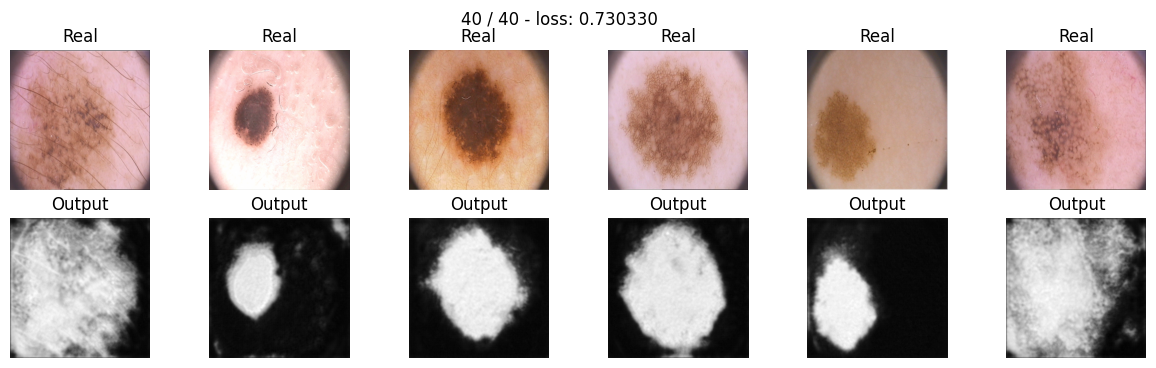

In [22]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
dice_results, dice_accuracy = train(model_dice, optimaizer, 
                                   dice_loss, max_epochs, data_tr, data_val)

In [23]:
print('VALID:\t', score_model(model_dice, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(model_dice, iou_pytorch, data_ts))

VALID:	 0.46400000154972076 
TEST:	 0.5600000023841858


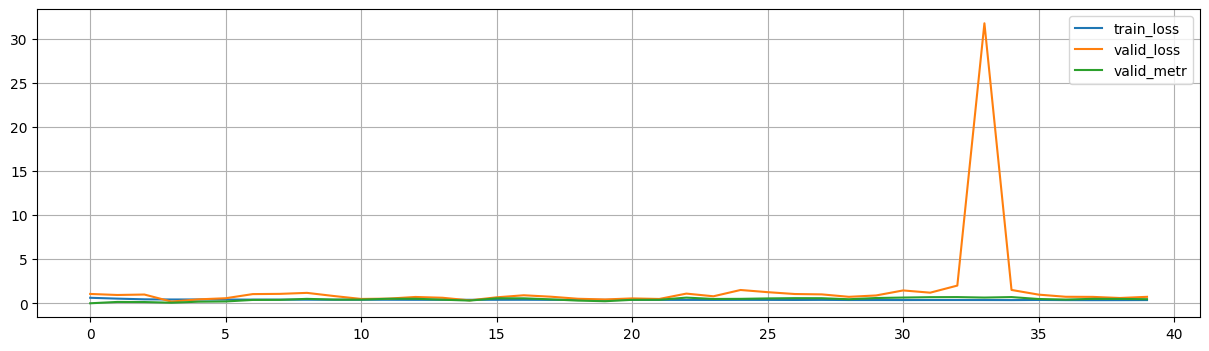

In [24]:
res, acc = dice_results, dice_accuracy
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [25]:
torch.cuda.empty_cache()

In [26]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    your_loss = ((1 - torch.sigmoid(y_pred))**gamma).mean() * bce_loss(y_real, y_pred)
    return your_loss

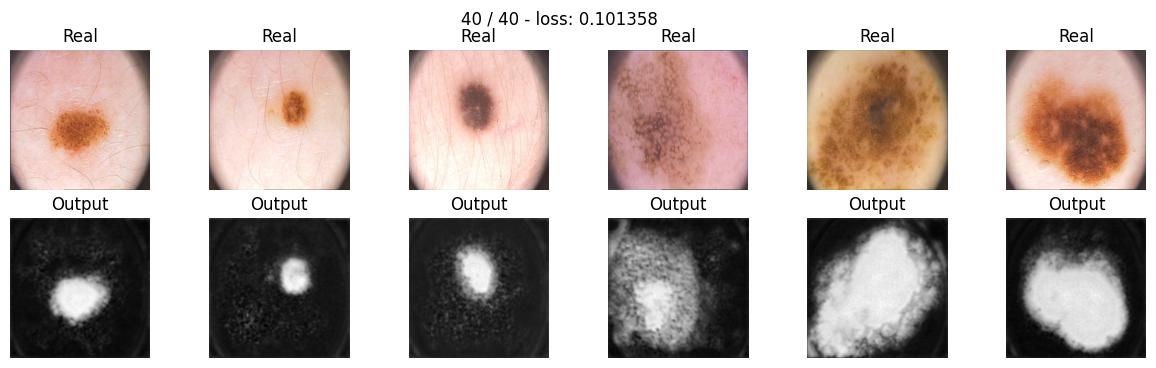

In [27]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
focal_results, focal_accuracy = train(model_focal, optimaizer, 
                                      focal_loss, max_epochs, data_tr, data_val)

In [28]:
print('VALID:\t', score_model(model_focal, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(model_focal, iou_pytorch, data_ts))

VALID:	 0.578000009059906 
TEST:	 0.5539999902248383


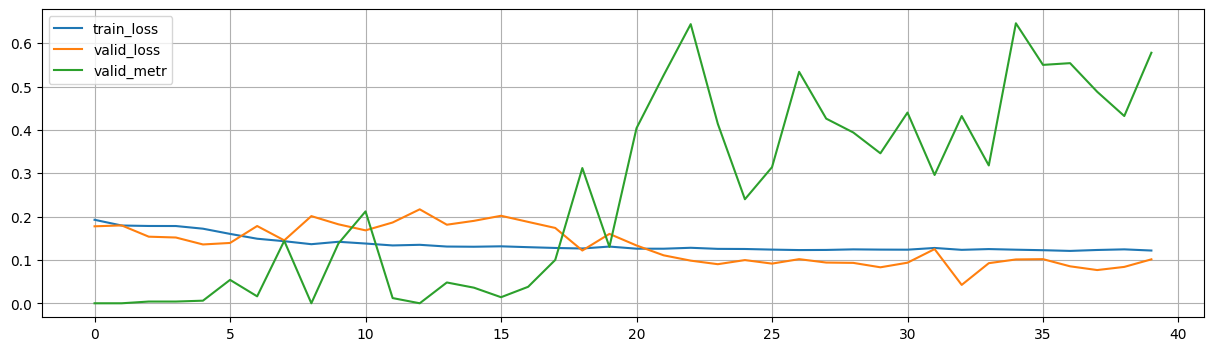

In [29]:
res, acc = focal_results, focal_accuracy
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [62]:
torch.cuda.empty_cache()

In [66]:
def tversky_loss(y_real, y_pred, beta=0.7, alpha=0.3):
    y_real = nn.Flatten()(y_real)
    y_pred = nn.Flatten()(y_pred.sigmoid())
    
    tp = torch.sum(y_real * y_pred)
    fp = torch.sum((1 - y_real) * y_pred)
    fn = torch.sum(y_real * (1 - y_pred))
 
    return 1 - tp / (tp + alpha * fp + beta * fn + 1e-8)

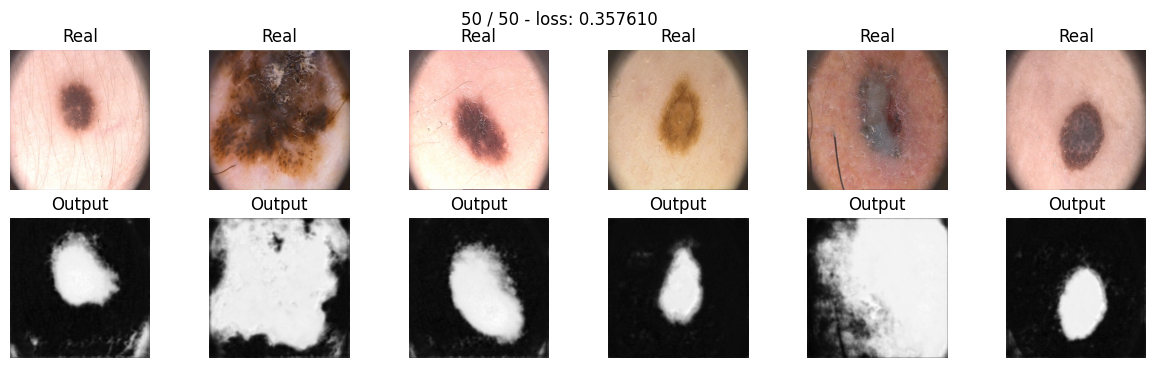

In [67]:
model_tversky = SegNet().to(device)

max_epochs = 50
optimaizer = optim.Adam(model_tversky.parameters())
tversky_results, tversky_accuracy = train(model_tversky, optimaizer, 
                                      tversky_loss, max_epochs, data_tr, data_val)

In [68]:
print('VALID:\t', score_model(model_tversky, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(model_tversky, iou_pytorch, data_ts))

VALID:	 0.5019999742507935 
TEST:	 0.6079999804496765


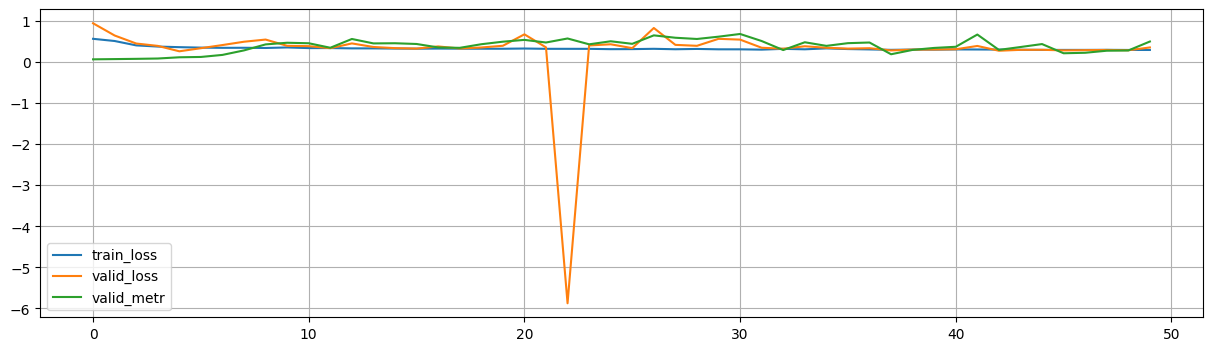

In [69]:
res, acc = tversky_results, tversky_accuracy
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [71]:
def boundary_loss(y_real, y_pred, beta=2):
    y_real = nn.Flatten()(y_real)
    y_pred = nn.Flatten()(y_pred.sigmoid())
    
    intersection = torch.sum(y_real * y_pred)
    dice = (2. * intersection) / (torch.sum(y_real) + torch.sum(y_pred) + 1e-8)
    boundary_loss = 1 - dice ** beta

    return boundary_loss

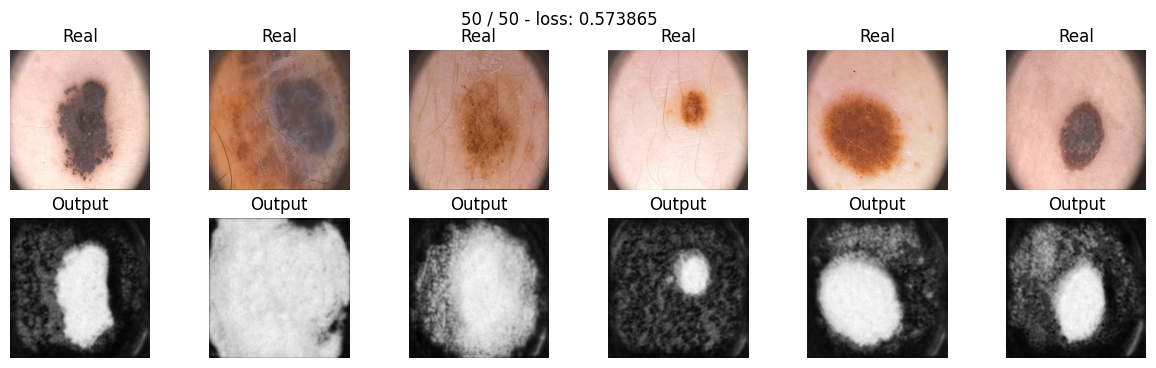

In [72]:
model_boundary = SegNet().to(device)

max_epochs = 50
optimaizer = optim.Adam(model_boundary.parameters())
boundary_results, boundary_accuracy = train(model_boundary, optimaizer, 
                                      boundary_loss, max_epochs, data_tr, data_val)

In [73]:
print('VALID:\t', score_model(model_boundary, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(model_boundary, iou_pytorch, data_ts))

VALID:	 0.27799999713897705 
TEST:	 0.318000003695488


In [31]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 1, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 1, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        enc_conv0 = self.enc_conv0(x)
        enc0, i0 = self.pool0(enc_conv0)
        enc_conv1 = self.enc_conv1(enc0)
        enc1, i1 = self.pool1(enc_conv1)
        enc_conv2 = self.enc_conv2(enc1)
        enc2, i2 = self.pool2(enc_conv2)
        enc_conv3 = self.enc_conv3(enc2)
        enc3, i3 = self.pool3(enc_conv3)      

        # bottleneck        
        b = self.bottleneck_conv(enc3)

        # decoder
        dec0 = self.dec_conv0(torch.cat([self.upsample0(b, i3), enc_conv3], 1))
        dec1 = self.dec_conv1(torch.cat([self.upsample1(dec0, i2), enc_conv2], 1))
        dec2 = self.dec_conv2(torch.cat([self.upsample2(dec1, i1), enc_conv1], 1))
        dec3 = self.dec_conv3(torch.cat([self.upsample3(dec2, i0), enc_conv0], 1))
        return dec3

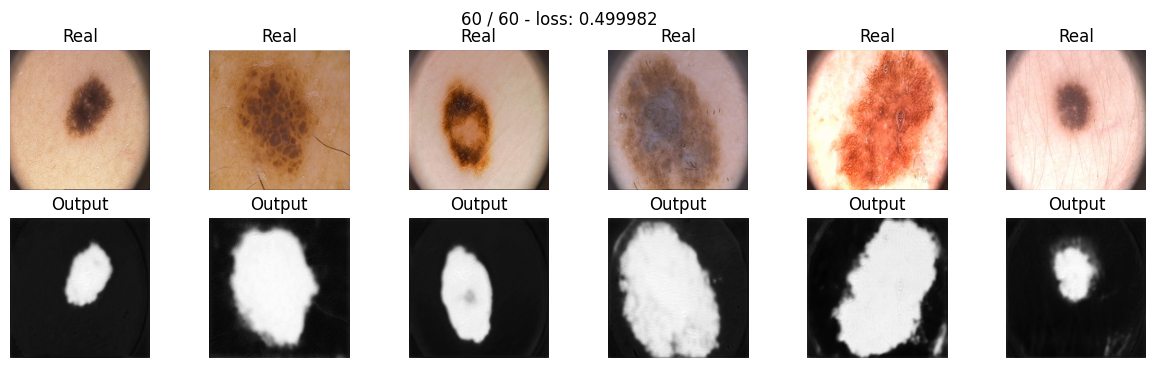

In [32]:
unet_model = UNet().to(device)
unet_results, unet_accuracy = train(unet_model, optim.Adam(unet_model.parameters()), 
                                    bce_loss, 60, data_tr, data_val)

In [33]:
print('VALID:\t', score_model(unet_model, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(unet_model, iou_pytorch, data_ts))

VALID:	 0.7220000326633453 
TEST:	 0.7380000352859497


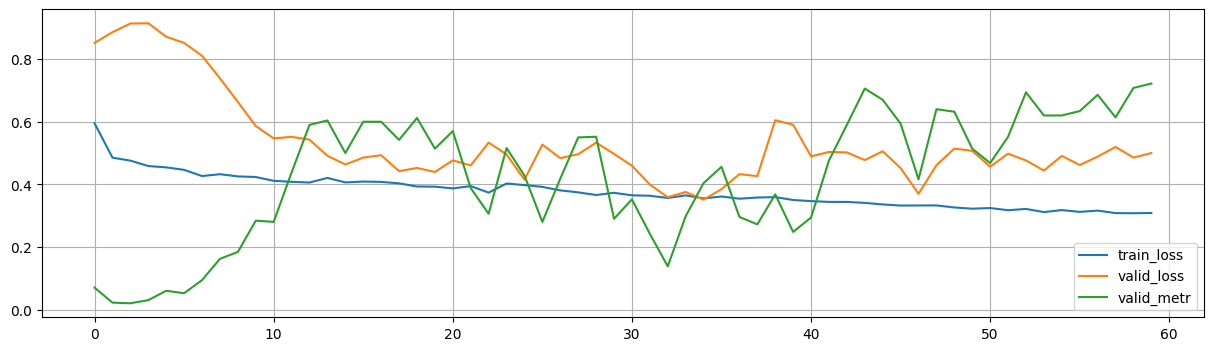

In [34]:
res, acc = unet_results, unet_accuracy
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

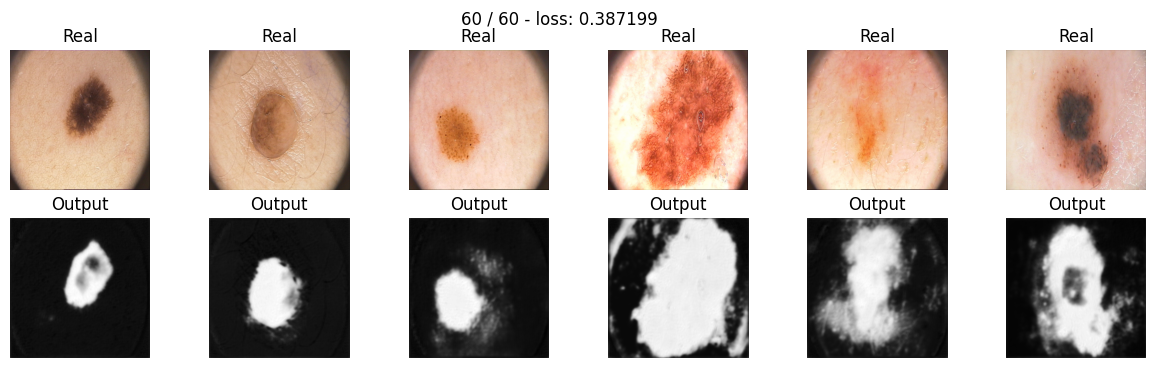

In [75]:
torch.cuda.empty_cache()
unet_model_tversky = UNet().to(device)
unet_results_t, unet_accuracy_t = train(unet_model_tversky, optim.Adam(unet_model_tversky.parameters()), 
                                    tversky_loss, 60, data_tr, data_val)

In [76]:
print('VALID:\t', score_model(unet_model_tversky, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(unet_model_tversky, iou_pytorch, data_ts))

VALID:	 0.49799999594688416 
TEST:	 0.6140000224113464


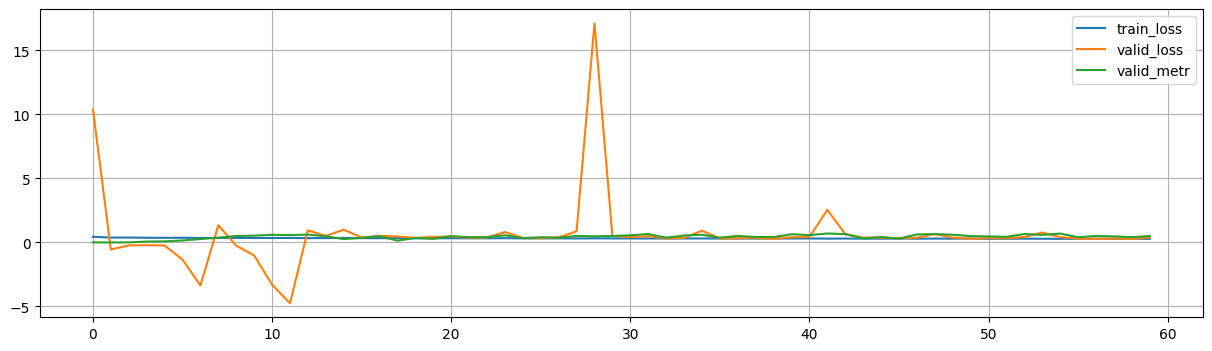

In [77]:
res, acc = unet_results_t, unet_accuracy_t
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

In [35]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.Conv2d(128, 128, 3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.Conv2d(256, 256, 3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.Conv2d(512, 512, 3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 1, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 1, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        enc_conv0 = self.enc_conv0(x)
        enc0  = self.pool0(enc_conv0)
        enc_conv1 = self.enc_conv1(enc0)
        enc1  = self.pool1(enc_conv1)
        enc_conv2 = self.enc_conv2(enc1)
        enc2  = self.pool2(enc_conv2)
        enc_conv3 = self.enc_conv3(enc2)
        enc3  = self.pool3(enc_conv3)        

        # bottleneck        
        b = self.bottleneck_conv(enc3)

        # decoder
        dec0 = self.dec_conv0(torch.cat([self.upsample0(b, 
                                        output_size=enc_conv3.size()), enc_conv3], 1))
        dec1 = self.dec_conv1(torch.cat([self.upsample1(dec0, 
                                        output_size=enc_conv2.size()), enc_conv2], 1))
        dec2 = self.dec_conv2(torch.cat([self.upsample2(dec1, 
                                        output_size=enc_conv1.size()), enc_conv1], 1))
        dec3 = self.dec_conv3(torch.cat([self.upsample3(dec2, 
                                        output_size=enc_conv0.size()), enc_conv0], 1))
        return dec3

In [36]:
unet2_model = UNet2().to(device)
torch.cuda.empty_cache()

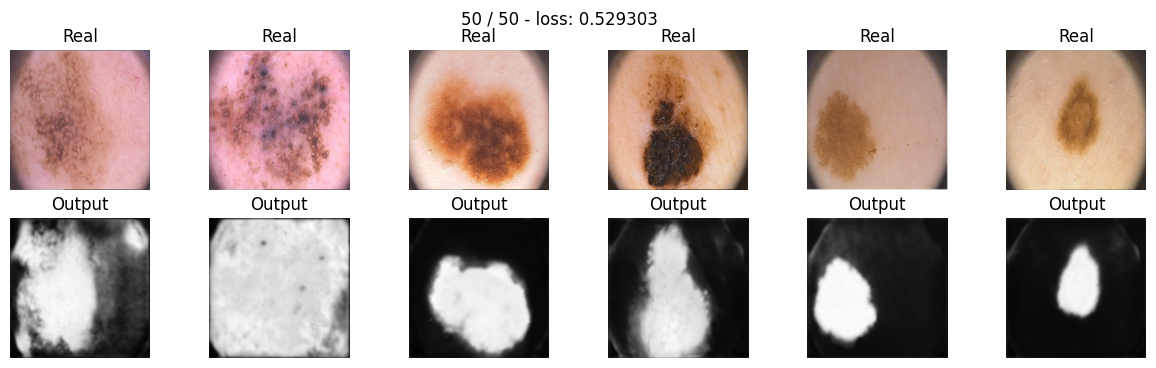

In [37]:
unet2_results, unet2_accuracy = train(unet2_model, optim.Adam(unet2_model.parameters()), 
                                      bce_loss, 50, data_tr, data_val)

In [38]:
print('VALID:\t', score_model(unet2_model, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(unet2_model, iou_pytorch, data_ts))

VALID:	 0.5799999833106995 
TEST:	 0.5780000388622284


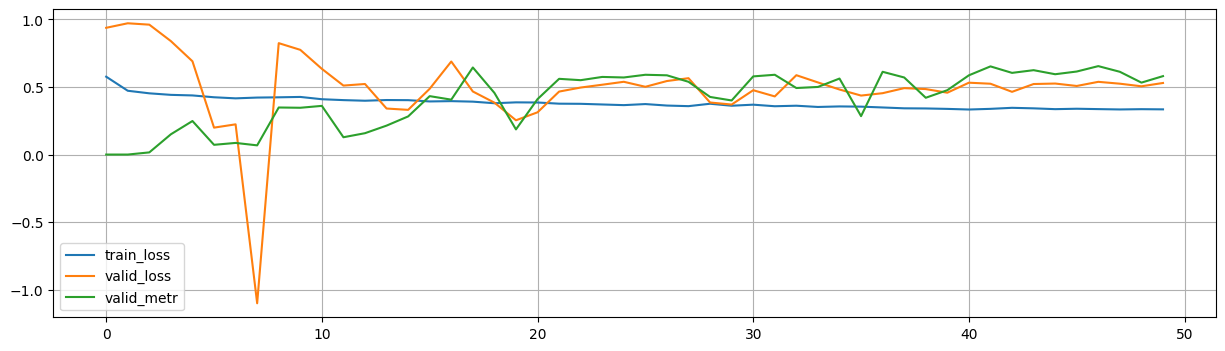

In [39]:
res, acc = unet2_results, unet2_accuracy
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();

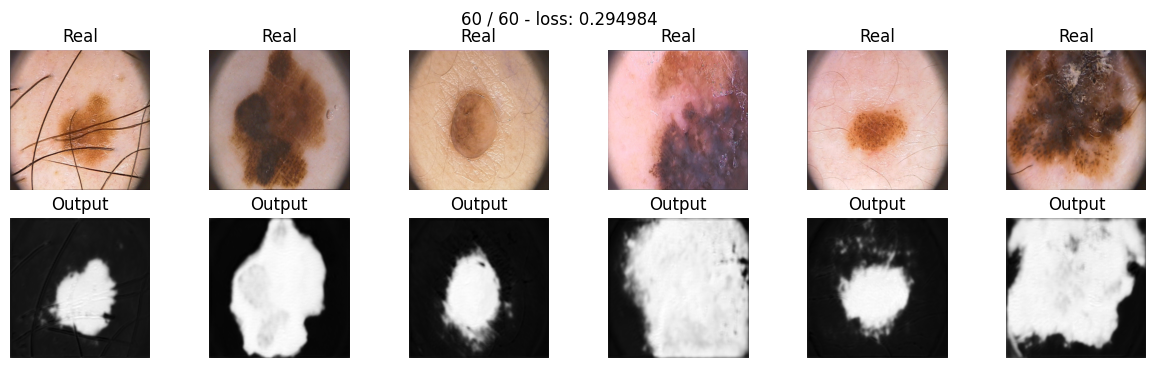

In [78]:
torch.cuda.empty_cache()
unet2_model_tversky = UNet2().to(device)
unet2_results_t, unet2_accuracy_t = train(unet2_model_tversky, optim.Adam(unet2_model_tversky.parameters()), 
                                    tversky_loss, 60, data_tr, data_val)

In [79]:
print('VALID:\t', score_model(unet2_model_tversky, iou_pytorch, data_val), 
      '\nTEST:\t', score_model(unet2_model_tversky, iou_pytorch, data_ts))

VALID:	 0.41199998557567596 
TEST:	 0.44200000166893005


# Выводы

1) Испытание модели SegNet.
На испытании модели SegNet среди всех функций лосса лучше всех показал себя BCE лосс со следующими результатами:

VALID: 0.5879999995231628 

TEST: 0.5539999604225159

Хотя довольно близким к нему оказался Focal loss со следующими результатами:

VALID: 0.578000009059906 

TEST: 0.5539999902248383

Для BCE хватило 30 эпох, при большем количестве модель начинала переобучаться. Для dice и focal брал 40, для Тверского брал 50.

Тверски показал себя следующим образом:

VALID: 0.5019999742507935 

TEST: 0.6079999804496765

Приведу результаты также на dice loss:

VALID: 0.46400000154972076 

TEST: 0.5600000023841858

Куда хуже показал себя приведенный мной boundary loss:

VALID: 0.27799999713897705 

TEST: 0.318000003695488

2) Unet (Unet2)

Unet на BCE показал себя лучше всех:

VALID: 0.7220000326633453 

TEST: 0.7380000352859497

Unet2 на BCE показал себя заметно хуже обычной Unet:

VALID: 0.5799999833106995 

TEST: 0.5780000388622284

Интересные результаты вышли у Unet на Тверски:

VALID: 0.49799999594688416 

TEST: 0.6140000224113464

Следующие результаты вышли у Unet2 на Тверски:

VALID: 0.41199998557567596 

TEST: 0.44200000166893005


Из всех приведенных моделей лучше всех показала себя Unet с лоссом BCE.